In [1]:
import yt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import sys
from pathlib import Path
sys.path.append('../src')
from load_derived_FLASH_fields import derive_fields

In [2]:
from datetime import datetime

datetime.today().strftime('%Y-%m-%d %H:%M:%S')

'2024-11-08 08:47:48'

In [9]:
# make plot text bigger

import matplotlib.pylab as pylab
import yt.config
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [10]:
# plot_path = "/home/dschneidinger/cellar/DEREK2/MagShockZ_hdf5_chk_0005"
# plot_path = "/home/dschneidinger/cellar/OSIRIS_transfer/MAGON/MagShockZ_hdf5_chk_0005"
# plot_path = "/home/dschneidinger/cellar/VAC_DEREK3D_20um/MagShockZ_hdf5_chk_0006"
plot_path = "/home/dschneidinger/cellar/VAC_DEREK3D_20um/MagShockZ_hdf5_chk_0016"

ds = derive_fields(plot_path)
# ds = yt.load(plot_path)

yt : [INFO     ] 2024-11-08 08:50:09,643 Particle file found: MagShockZ_hdf5_chk_0016
yt : [INFO     ] 2024-11-08 08:50:09,671 Parameters: current_time              = 6.569260309240979e-09
yt : [INFO     ] 2024-11-08 08:50:09,673 Parameters: domain_dimensions         = [384 496 384]
yt : [INFO     ] 2024-11-08 08:50:09,674 Parameters: domain_left_edge          = [-0.8   -0.075 -0.8  ]
yt : [INFO     ] 2024-11-08 08:50:09,674 Parameters: domain_right_edge         = [0.8 2.  0.8]
yt : [INFO     ] 2024-11-08 08:50:09,674 Parameters: cosmological_simulation   = 0


In [11]:
ds.domain_dimensions

array([384, 496, 384], dtype=int32)

In [12]:
mins = ds.domain_left_edge
maxs = ds.domain_right_edge
print(mins)
print(maxs)

[-0.8   -0.075 -0.8  ] code_length
[0.8 2.  0.8] code_length


In [15]:
# create covering grid from ds
level = 1
dims = ds.domain_dimensions * ds.refine_by**level

# We construct an object that describes the data region and structure we want
# In this case, we want all data up to the maximum "level" of refinement
# across the entire simulation volume.  Higher levels than this will not
# contribute to our covering grid.

all_data = ds.covering_grid(
    level,
    left_edge=ds.domain_left_edge,
    dims=dims,
    # And any fields to preload (this is optional!)
)


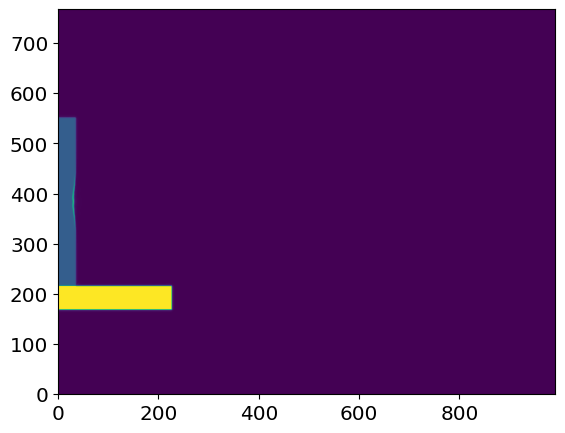

In [16]:

# density and electron temp at y=0
z_middle_index = dims[2] // 2
# dens = pd.DataFrame(all_data['flash', 'dens'][:, :, z_middle_index])
# tele = pd.DataFrame(all_data['flash', 'tele'][:, :, z_middle_index])

target_index = 0
plt.imshow(all_data['flash', 'dens'][:, target_index:, z_middle_index], origin='lower')

In [ ]:
plt.figure(figsize=(10,10))
im = plt.imshow(dens.T, norm=colors.LogNorm(), 
           cmap='plasma', origin='lower', extent=extents)
cbar = plt.colorbar(im, fraction=0.1, pad=0.04) # fraction and pad are for sizing the colorbar
cbar.set_label('mass density (g/$\mathregular{{cm}^3}$)')
plt.xlabel('r (cm)')
plt.ylabel('z (cm)')
plt.minorticks_on()
plt.xlim(0, extents[1])
plt.ylim(ylimmin, ylimmax)
plt.title("Mass density at t={} ns".format(time_pretty));
# plt.savefig("slice_mpl_{0}ns_{1}.png".format(time_pretty, datetime.today().strftime('%Y-%m-%d %H:%M:%S')), bbox_inches="tight")

In [ ]:
plt.figure(figsize=(10,10))
im = plt.imshow(tele.T, norm=colors.LogNorm(), 
           cmap='plasma', origin='lower', extent=extents)
cbar = plt.colorbar(im, fraction=0.1, pad=0.04)
cbar.set_label('temperature (K)')
plt.xlabel('r (cm)')
plt.ylabel('z (cm)')
plt.xlim(0, extents[1])
plt.ylim(ylimmin, ylimmax)
plt.title("Electron temp at t={} ns".format(time_pretty));
# plt.savefig("slice_mpl_{0}ns_{1}.png".format(time_pretty, datetime.today().strftime('%Y-%m-%d %H:%M:%S')), bbox_inches="tight")

yt : [INFO     ] 2024-11-08 08:57:38,725 xlim = -0.800000 0.800000
yt : [INFO     ] 2024-11-08 08:57:38,729 ylim = 0.132500 2.207500
yt : [INFO     ] 2024-11-08 08:57:38,732 xlim = -0.800000 0.800000
yt : [INFO     ] 2024-11-08 08:57:38,733 ylim = 0.132500 2.207500
yt : [INFO     ] 2024-11-08 08:57:38,737 Making a fixed resolution buffer of (('flash', 'edens')) 800 by 800
yt : [INFO     ] 2024-11-08 08:57:39,529 Saving plot ../results/FLASH_plots/edens_slice.png



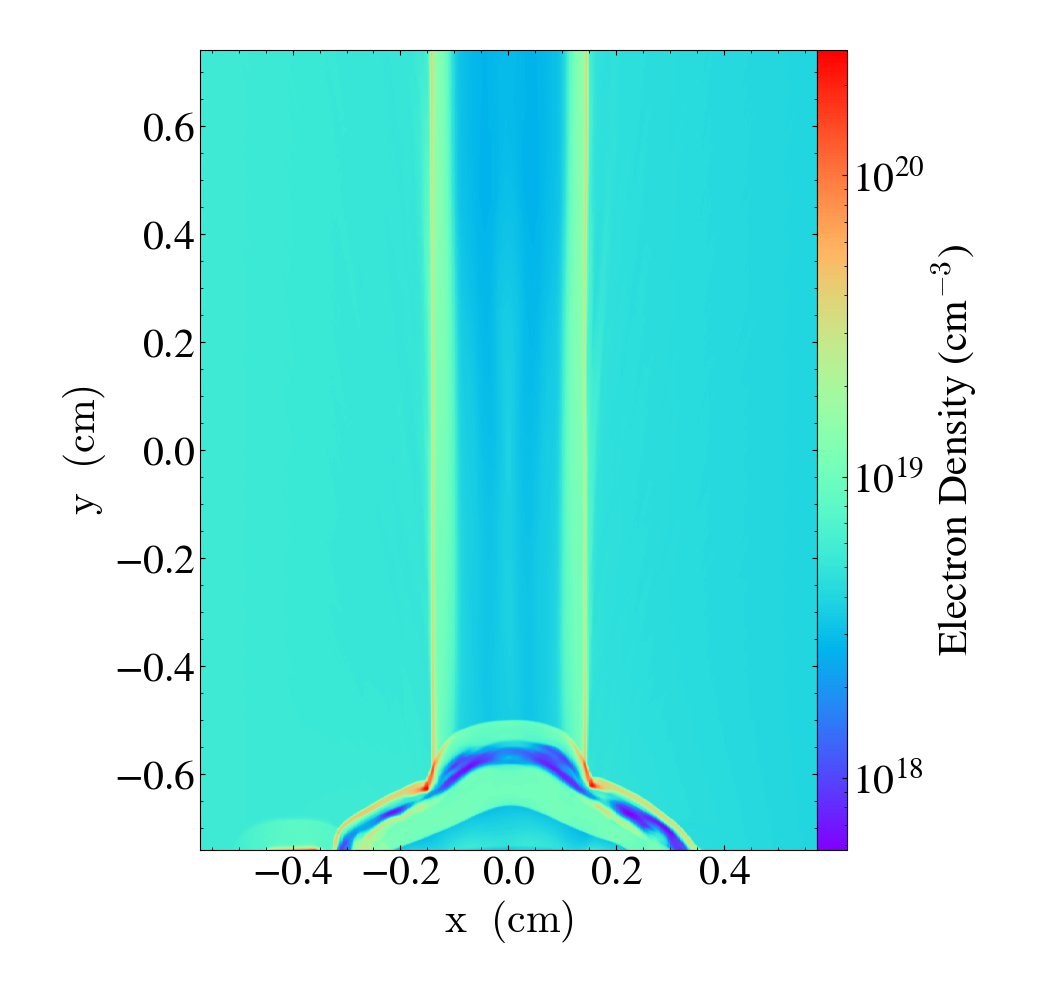

In [17]:
# you can get a very rough slice plot using the native yt plotter
slc = yt.SlicePlot(ds, "z", ("flash","edens"),center = [0,1.17,0]).zoom(1.4).set_cmap("edens","rainbow")
slc.set_font_size(30)
slc.set_colorbar_label("edens", r"Electron Density (cm$^{-3}$)")
# slc.save("../results/FLASH_plots/edens_slice.png")
slc.show()

In [ ]:
# you can get a very rough slice plot using the native yt plotter
slc = yt.SlicePlot(ds, "z", ("flash","aldens")).zoom(1.2).set_cmap("aldens","rainbow")
slc.set_font_size(30)
slc.set_colorbar_label("idens", r"Aluminum Density (g/cm$^3$)")
slc.save("../results/FLASH_plots/aldens_slice.png")
slc.show()

In [ ]:
slc = yt.SlicePlot(ds, "z", ("flash","magp")).zoom(1.2).set_cmap("magp","rainbow")
# slc.set_log("magp", False)
slc.set_colorbar_label("magp", "magnetic pressure (Ba)")
slc.set_font_size(30)
slc.save("../results/FLASH_plots/magp_slice.png")
slc.show()

In [ ]:
slc = yt.SlicePlot(ds, "z", ("flash","tele")).zoom(1.2).set_cmap("tele","Reds")
kb = 8.617333262e-5
# slc.set_log("tele", False)
slc.frb["flash","tele"] *= kb
slc.set_colorbar_label("tele", "electron temp (eV)")
slc.set_font_size(30)
slc.save("../results/FLASH_plots/tele_slice.png")
slc.show()

In [ ]:
slc = yt.SlicePlot(ds, "z", ("flash","tion")).zoom(1.2).set_cmap("tion","Reds")
kb = 8.617333262e-5
slc.frb["flash","tion"] *= kb
slc.set_colorbar_label("tion", "ion temp (eV)")
slc.set_font_size(30)
slc.save("../results/FLASH_plots/tion_slice.png")
slc.show()

In [ ]:
slc = yt.SlicePlot(ds, "z", ("flash","vely")).zoom(1.2).set_cmap("vely","rainbow")
slc.set_log("vely", False)
aluminum_molecular_weight = 26.98
proton_mass = 1.6726219e-24
ne_cgs = 5e18
Al_charge_state = 6
rho_0 = aluminum_molecular_weight*proton_mass*ne_cgs/Al_charge_state
v_alfven = 150000/np.sqrt(4*np.pi*rho_0)
print(v_alfven)
slc.frb["flash","vely"] = slc.frb["flash","vely"]/v_alfven
slc.set_colorbar_label("vely", "$v_y$ ($v_A$)")
slc.save("../results/FLASH_plots/vely_slice.png")
slc.show()

In [ ]:
plot_path = "/home/dschneidinger/cellar/DEREK2/MagShockZ_hdf5_chk_0005"
# plot_path = "/home/dschneidinger/cellar/OSIRIS_transfer/MAGON/MagShockZ_hdf5_chk_0005"

sys.path.append("../src")
ds = derive_fields(plot_path)

In [ ]:
# you can get a very rough slice plot using the native yt plotter
slc = yt.SlicePlot(ds, "z", ("flash","edens")).zoom(1).set_cmap("edens","rainbow")
slc.set_font_size(30)
slc.set_colorbar_label("edens", r"Electron Density (cm$^{-3}$)")
slc.set_zlim("edens", 1e18, 8e21)
slc.save("../results/FLASH_plots/edens_slice_with_shield.png")
slc.show()